In [30]:
import matplotlib.pyplot as plt
import pathlib
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm.auto import tqdm

In [31]:
stevilo_razredov = 5
visina_slike, sirina_slike = 600, 600
velikost_slike = (visina_slike, sirina_slike)
potDatoteke = pathlib.Path('./../GeneriranjeSlik/slike_generirane/data')
print('Število vseh slik v mapah: ' + str(len(list(potDatoteke.glob('*/*.png')))))

Število vseh slik v mapah: 500


Resize images to 600x600 for EfficientNetB7

In [32]:
for dirpath, dirnames, filenames in os.walk("./../GeneriranjeSlik/slike_generirane/data"):
  for filename in tqdm(filenames):
    if filename.endswith(".png"):
      im = Image.open(os.path.join(dirpath, filename))
      if im.size != velikost_slike:
        im = im.resize(velikost_slike)
        im.save(os.path.join(dirpath, filename))

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[100, 100, 100, 100, 100]


[Text(0, 0, 'razred1'),
 Text(1, 0, 'razred2'),
 Text(2, 0, 'razred3'),
 Text(3, 0, 'razred4'),
 Text(4, 0, 'razred5')]

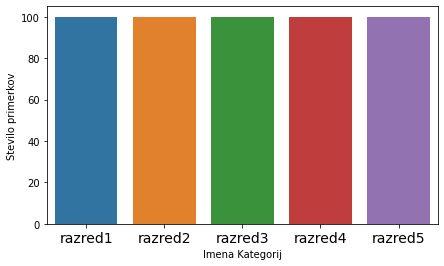

In [33]:
#štetje slik
PticaRibaMacka = [] #ustvari/sprazni array

# Naslednji del kode prešteje število slik v mapah (število mora bit identično za učenje!!)
for dirpath, dirnames, filenames in os.walk("./../GeneriranjeSlik/slike_generirane/data"):
    stevilo = len(filenames)
    if (stevilo != 0 and stevilo != 1):
      PticaRibaMacka.append(stevilo)

# Naslednji del kode prešteje število testnih slik v mapi ".../test"
for dirpath, dirnames, filenames in os.walk("./../GeneriranjeSlik/slike_generirane/test"):
    stevilo = len(filenames)
    if stevilo != 1 and stevilo != 0:
        PticaRibaMacka.append(stevilo)

# Ta del kode pridobi imena kategorij iz imen map
imena_kategorij = [] #ustvari/sprazni array
for root, dirs, files in os.walk("./../GeneriranjeSlik/slike_generirane/data", topdown=False):
    for name in dirs:
        imena_kategorij.append(os.path.join(name))

print(PticaRibaMacka)          
# imena_kategorij.append("testna")
#izris grafa
fig_dims = (7,4)
fig, ax = plt.subplots(figsize=fig_dims)

#Ustvarjanje dataframea (iz slovarja) za stolpični graf
slovar = pd.DataFrame.from_dict({"Imena Kategorij":imena_kategorij, "Stevilo primerkov":PticaRibaMacka})
bar = sns.barplot(data = slovar, x = "Imena Kategorij", y = "Stevilo primerkov", ax=ax)

bar.set_xticklabels(bar.get_xmajorticklabels(), fontsize = 14)

In [34]:
#Velikost serije batch
velikost_serije = 32

ucna_mnozica = tf.keras.preprocessing.image_dataset_from_directory(
    potDatoteke,
    validation_split=0.2,
    label_mode="int",
    subset="training",
    seed=1337,
    image_size=(velikost_slike),
    batch_size=velikost_serije,
)

#print(ucna_mnozica)
testna_mnozica = tf.keras.preprocessing.image_dataset_from_directory(
    potDatoteke,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(velikost_slike),
    batch_size=velikost_serije,
)
imena_razredov = testna_mnozica.class_names

Found 500 files belonging to 5 classes.
Using 400 files for training.
Found 500 files belonging to 5 classes.
Using 100 files for validation.


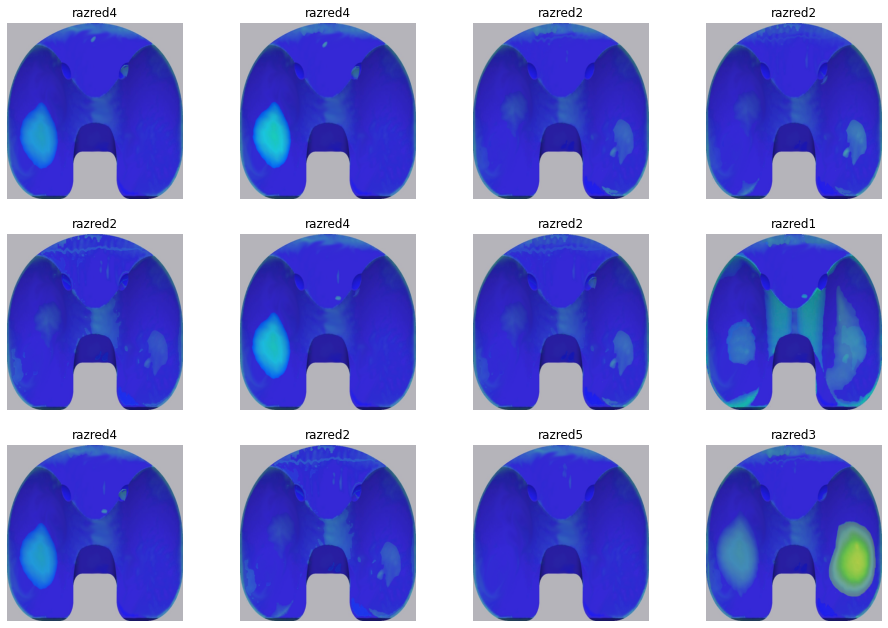

In [35]:
plt.figure(figsize=(16, 11))
for images, labels in ucna_mnozica.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(imena_razredov[labels[i]])
        plt.axis("off")

In [36]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip('vertical', input_shape=(visina_slike, sirina_slike, 3)),
        layers.experimental.preprocessing.RandomRotation(0.3),
        layers.experimental.preprocessing.RandomZoom(0.3),
    ]
)

In [37]:
RGB = 3
inputs = keras.Input(shape=(visina_slike, sirina_slike, RGB))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)

AUTOTUNE = tf.data.experimental.AUTOTUNE

ucna_mnozica = ucna_mnozica.prefetch(buffer_size=AUTOTUNE)
testna_mnozica = testna_mnozica.prefetch(buffer_size=AUTOTUNE)

In [38]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [39]:
from tensorflow.keras.applications import EfficientNetB7
import time

inputs = layers.Input(shape=(visina_slike, sirina_slike, RGB)) # Default shape za B7 je 600*600
x = data_augmentation(inputs)
# model = EfficientNetB7(include_top=False, input_tensor=x, weights='imagenet')
model = EfficientNetB7(include_top=False, input_tensor=x, weights='imagenet')

model.trainable = False

x = layers.GlobalAveragePooling2D(name="gap")(model.output)
x = layers.BatchNormalization()(x)

#avoid overfitting
top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(5, activation="softmax")(x) # 5 je število kategorij
 
# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNetB7")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer,
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=[
                   "accuracy",
                   'MeanSquaredError',
                   ])
epochs = 35  # @param {type: "slider", min:5, max:100}

zacetni_cas = time.time()

history = model.fit(ucna_mnozica, epochs=epochs, validation_data=testna_mnozica, verbose=1) # verbose: 'auto', 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 
koncni_cas = time.time()
cas_trajanja = koncni_cas - zacetni_cas
print("Čas trajanja učenja modela: " + str(cas_trajanja))

tocnost = history.history['accuracy'] #metrika tocnosti accuracy

Epoch 1/35


c:\Users\Potatoseus\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


13/13 [==============================] - 43s 2s/step - loss: 1.6458 - accuracy: 0.7150 - mean_squared_error: 5.2752 - val_loss: 1.1442 - val_accuracy: 0.5100 - val_mean_squared_error: 5.7226
Epoch 2/35
13/13 [==============================] - 19s 1s/step - loss: 0.6799 - accuracy: 0.8950 - mean_squared_error: 5.2906 - val_loss: 1.3527 - val_accuracy: 0.4100 - val_mean_squared_error: 5.7458
Epoch 3/35
13/13 [==============================] - 19s 1s/step - loss: 0.4002 - accuracy: 0.9200 - mean_squared_error: 5.2930 - val_loss: 2.1825 - val_accuracy: 0.5400 - val_mean_squared_error: 5.7739
Epoch 4/35
13/13 [==============================] - 19s 1s/step - loss: 0.3757 - accuracy: 0.9325 - mean_squared_error: 5.2937 - val_loss: 1.9336 - val_accuracy: 0.4800 - val_mean_squared_error: 5.7772
Epoch 5/35
13/13 [==============================] - 19s 1s/step - loss: 0.4510 - accuracy: 0.9200 - mean_squared_error: 5.2944 - val_loss: 1.2413 - val_accuracy: 0.7500 - val_mean_squared_error: 5.7789
E

In [40]:
saved_model_dir = './MainModel/'
model.save(saved_model_dir)

INFO:tensorflow:Assets written to: ./MainModel/assets


INFO:tensorflow:Assets written to: ./MainModel/assets


In [41]:
np.save('./MainModelHistory.npy', history)

INFO:tensorflow:Assets written to: ram://919965f0-d0f0-4ca1-ba80-35c43ee2baa8/assets


INFO:tensorflow:Assets written to: ram://919965f0-d0f0-4ca1-ba80-35c43ee2baa8/assets


In [42]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('./model.tflite', 'wb') as f:
  f.write(tflite_model)

# Podatki o ucenju modela

dict_keys(['loss', 'accuracy', 'mean_squared_error', 'val_loss', 'val_accuracy', 'val_mean_squared_error'])


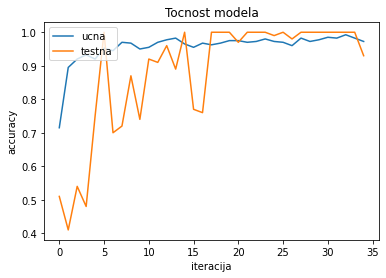

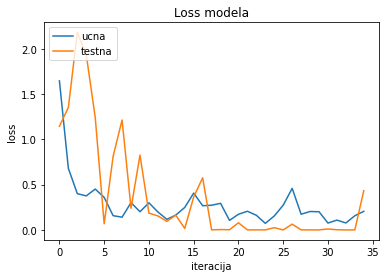

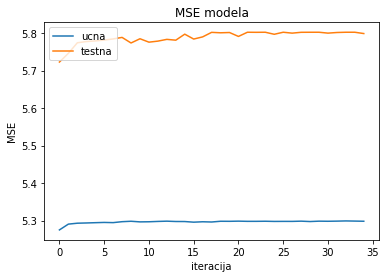

In [46]:
#history=np.load('./MainModelHistory.npy', allow_pickle='TRUE').item() # Podatki o poteku učenja modela

# list all data in history
history = history.history
print(history.keys()) #kaj imamo na razpolago (dodan MSE)

# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Tocnost modela')
plt.ylabel('accuracy')
plt.xlabel('iteracija')
plt.legend(['ucna', 'testna'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss modela')
plt.ylabel('loss')
plt.xlabel('iteracija')
plt.legend(['ucna', 'testna'], loc='upper left')
plt.show()
# summarize history for mean squared error
plt.plot(history['mean_squared_error'])
plt.plot(history['val_mean_squared_error'])
plt.title('MSE modela')
plt.ylabel('MSE')
plt.xlabel('iteracija')
plt.legend(['ucna', 'testna'], loc='upper left')
plt.show()



1/1 [==============================] - 0s 160ms/step
Ime napovedanega razreda: razred1, napovedano s 100.0 % točnostjo


C:\Users\Potatoseus\AppData\Local\Temp\ipykernel_22464\3178795810.py:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((basewidth,hsize), Image.ANTIALIAS)


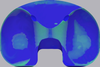

1/1 [==============================] - 0s 84ms/step
Ime napovedanega razreda: razred1, napovedano s 100.0 % točnostjo


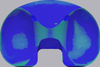

1/1 [==============================] - 0s 77ms/step
Ime napovedanega razreda: razred1, napovedano s 100.0 % točnostjo


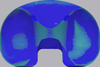

1/1 [==============================] - 0s 61ms/step
Ime napovedanega razreda: razred2, napovedano s 99.75831508636475 % točnostjo


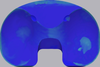

1/1 [==============================] - 0s 71ms/step
Ime napovedanega razreda: razred2, napovedano s 100.0 % točnostjo


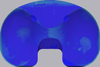

1/1 [==============================] - 0s 79ms/step
Ime napovedanega razreda: razred2, napovedano s 100.0 % točnostjo


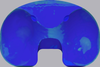

1/1 [==============================] - 0s 89ms/step
Ime napovedanega razreda: razred3, napovedano s 100.0 % točnostjo


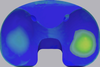

1/1 [==============================] - 0s 64ms/step
Ime napovedanega razreda: razred3, napovedano s 100.0 % točnostjo


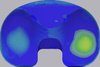

1/1 [==============================] - 0s 66ms/step
Ime napovedanega razreda: razred3, napovedano s 100.0 % točnostjo


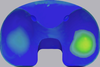

1/1 [==============================] - 0s 62ms/step
Ime napovedanega razreda: razred4, napovedano s 97.49683141708374 % točnostjo


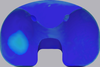

1/1 [==============================] - 0s 61ms/step
Ime napovedanega razreda: razred4, napovedano s 98.82379174232483 % točnostjo


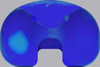

1/1 [==============================] - 0s 66ms/step
Ime napovedanega razreda: razred4, napovedano s 99.9072790145874 % točnostjo


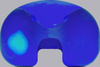

1/1 [==============================] - 0s 67ms/step
Ime napovedanega razreda: razred5, napovedano s 100.0 % točnostjo


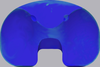

1/1 [==============================] - 0s 73ms/step
Ime napovedanega razreda: razred5, napovedano s 100.0 % točnostjo


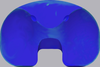

1/1 [==============================] - 0s 63ms/step
Ime napovedanega razreda: razred5, napovedano s 100.0 % točnostjo


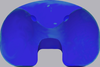

In [48]:
# model = keras.models.load_model("./MainModel") # Naš natreniran model

dejanski_array = ["razred1", "razred1", "razred1", "razred2", "razred2", "razred2", 'razred3', 'razred3', 'razred3', 'razred4', 'razred4', 'razred4', 'razred5', 'razred5', 'razred5']
predikcija_array = []

for i in range(0, len(dejanski_array)):
    img = keras.preprocessing.image.load_img(
      "./../GeneriranjeSlik/slike_generirane/test/"+str(i)+".png", target_size=(visina_slike, sirina_slike)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    score = predictions[0]

    tocnost = tf.nn.softmax(predictions[0])

    predikcija_array.append(imena_razredov[np.argmax(tocnost)])

    # Izpis napovedanega razreda
    print("Ime napovedanega razreda: " + imena_razredov[np.argmax(score)] + ", napovedano s " + str(100 * np.amax(score)) + " % točnostjo")

    # Prikaz slike + resize na 100*razmerje - posledično bistveno manjši ipynb file
    img = Image.open(str("./../GeneriranjeSlik/slike_generirane/test/"+str(i)+".png"))
    basewidth = 100
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    display(img)